In [1]:
from math import radians, cos, sin, asin, sqrt

# Read in two created tables
1. sales
2. developments

In [2]:
sales = pd.read_csv("../created_tables/sales.csv")
developments = pd.read_csv("../created_tables/developments.csv")

In [3]:
test = sales[0:2]

In [4]:
testpoint = sales.centroid[0]
 

In [5]:
testpoint

'(-86.76150711122163,36.394839711854296)'

In [6]:
#res = tuple(map(int, test_str.split(', ')))
testpoint = tuple(map(float,testpoint.replace('(','').replace(')','').split(',')))

In [7]:
type(testpoint)

tuple

In [8]:
def calculate_distance(p1, p2):

    #latitudes
    x1 = radians(p1[1]) 
    x2 = radians(p2[1])
    
    #longitudes
    y1 = radians(p1[0])
    y2 = radians(p2[0]) 

    #Haversine formula
    dx = x2 - x1
    dy = y2 - y1

    grossmath = (
        sin(dx / 2)**2 + cos(x1) * cos(x2) * sin(dy / 2)**2
    )

    angle = 2 * asin(sqrt(grossmath))

    earth_radius_miles = 3956

    return angle * earth_radius_miles



In [9]:
# 35.1495° N, 90.0490° W
# 36.1627° N, 86.7816° W
memphis = (-90.0490,35.1495)
nashville = (-86.7816, 36.1627)

distance = calculate_distance(memphis, nashville)

print(f"the distance between nashville and memphis is {distance} miles")

the distance between nashville and memphis is 196.1874733983198 miles


# Convert sales centroid to actual tuple point that we can use

In [10]:
dummy_tuple_list = [(0.001,0.001) for x in range(183503)]

In [11]:
sales['clean_center'] = dummy_tuple_list

In [12]:
for index, row in sales.iterrows():
    curr = row.centroid
    newtuple = tuple(map(float, curr.replace('(','').replace(')','').split(',') ))
    sales.at[index, 'clean_center'] = newtuple

# Check centroid of developments

In [13]:
developments.dtypes

name        object
address     object
lat        float64
lng        float64
year         int64
dtype: object

looks good

# test distance function on two values in our actual dataframes

In [14]:
p1 = sales.clean_center[0]
p2 = (developments.lng[0],developments.lat[0])

In [15]:
print(type(p1))
print(type(p2))

<class 'tuple'>
<class 'tuple'>


In [16]:
test_distance = calculate_distance(p1,p2)

In [17]:
print(f'distance between two features is {test_distance} miles')

distance between two features is 24.86798894660951 miles


**it works!!!!!**

# Get Sales Table Ready for analysis
- isolating min and max sale year
- sale diff


prepped_sales = "awesome table that theo designs tomorrow"

##### Distill Sales Table

In [18]:
view_columns = ['apn', 'ownerdate', 'sale_year', 'saleamount', 'total_sales','clean_center']
distilled_sales = sales[view_columns]

In [19]:
intentional error throw

SyntaxError: invalid syntax (3405418324.py, line 1)

##### turn owner date into datetime

In [20]:
for index, row in distilled_sales.iterrows():
    distilled_sales.loc[index,'ownerdate'] = pd.to_datetime(distilled_sales.loc[index, 'ownerdate'])

##### find first sale for each apn

In [21]:
min_sale_year = pd.DataFrame(sales.groupby('apn').ownerdate.min()).reset_index().rename(columns = {'ownerdate':'first_sale'})

In [22]:
for index, row in min_sale_year.iterrows():
    min_sale_year.loc[index, 'first_sale'] = pd.to_datetime(min_sale_year.loc[index, 'first_sale'])

In [23]:
min_sale_year.head(1)

apn           first_sale
0  00200000300  2010-12-22 00:00:00

In [24]:
distilled_sales.head(1)

apn            ownerdate  sale_year  saleamount  total_sales  \
0  00200004500  2021-12-10 00:00:00     2021.0    393000.0            2   

                               clean_center  
0  (-86.76150711122163, 36.394839711854296)

##### merge with distilled sales

In [210]:
intermediate_sales_analysis.head(1)

apn  sale_year  first_sale_amount  total_sales  \
0  00200004500     2019.0           272500.0            2   

                               clean_center           first_sale  
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00

In [25]:
intermediate_sales_analysis = pd.merge(distilled_sales, min_sale_year, how = 'inner',
                                 left_on = ['apn', 'ownerdate'], right_on = ['apn', 'first_sale'])

In [28]:
intermediate_sales_analysis = intermediate_sales_analysis.rename(columns = {'saleamount' : 'first_sale_amount'}).drop(columns = ['ownerdate'])

In [30]:
print(intermediate_sales_analysis.shape)
print(distilled_sales.shape)

(80355, 6)
(183503, 6)


#### find last sale for each apn 

In [35]:
max_sale_year = pd.DataFrame(sales.groupby('apn').ownerdate.max().reset_index().rename(columns = {'ownerdate' : 'last_sale'}))

In [36]:
for index, row in max_sale_year.iterrows():
    max_sale_year.loc[index, 'last_sale'] = pd.to_datetime(max_sale_year.loc[index, 'last_sale'])

In [43]:
intermediate_max_sales = pd.merge(
    distilled_sales, max_sale_year, how='inner', left_on=['apn','ownerdate'], right_on=['apn','last_sale']
    ).drop(columns = ['ownerdate']).rename(columns = {'saleamount' : 'last_sale_amount'})

#### merge with sales analysis to get to final analysis table

In [45]:
sales_analysis = pd.merge(
    intermediate_sales_analysis, intermediate_max_sales, how='inner', on=['apn', 'clean_center']
)

In [46]:
print(sales_analysis.shape)

(80355, 10)


**DROP ALL SALES THAT HAVE SAME FIRST SALE AND LAST SALE**

In [50]:
for index, row in sales_analysis.iterrows():
    if row.first_sale == row.last_sale:
        sales_analysis.drop(index, inplace=True)

**check for cases when first sale is in the same year as last sale**

In [52]:
sales_analysis.loc[sales_analysis.first_sale == sales_analysis.last_sale]

Empty DataFrame
Columns: [apn, sale_year_x, first_sale_amount, total_sales_x, clean_center, first_sale, sale_year_y, last_sale_amount, total_sales_y, last_sale]
Index: []

In [ ]:
intentional error throw

In [54]:
sales_analysis.head(2)

apn  sale_year_x  first_sale_amount  total_sales_x  \
0  00200004500       2019.0           272500.0              2   
1  00200002700       2020.0           165000.0              4   

                               clean_center           first_sale  sale_year_y  \
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00       2021.0   
1   (-86.76308736156855, 36.39356184510311)  2020-05-08 00:00:00       2022.0   

   last_sale_amount  total_sales_y            last_sale  
0          393000.0              2  2021-12-10 00:00:00  
1          440000.0              4  2022-08-12 00:00:00

# Main Loop to create goal table

In [55]:
developments.head(1)

name            address        lat        lng  \
0  RYMAN LOFTS AT ROLLING MILL HILL  100 MIDDLETON CIR  36.046509 -86.875031   

   year  
0  2010

**make sales table years an integer**

In [56]:
sales_analysis.dtypes

apn                   object
sale_year_x          float64
first_sale_amount    float64
total_sales_x          int64
clean_center          object
first_sale            object
sale_year_y          float64
last_sale_amount     float64
total_sales_y          int64
last_sale             object
dtype: object

In [57]:
sales_analysis.head(1)

apn  sale_year_x  first_sale_amount  total_sales_x  \
0  00200004500       2019.0           272500.0              2   

                               clean_center           first_sale  sale_year_y  \
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00       2021.0   

   last_sale_amount  total_sales_y            last_sale  
0          393000.0              2  2021-12-10 00:00:00

In [89]:
sales_analysis.reset_index(drop=True)
sales_analysis['closest_dev_distance'] = 9999
sales_analysis['dev_name'] = 'no_dev_constructed'
sales_analysis['dev_construction_year'] = 0

for sales_index, sales_row in sales_analysis.iterrows():
    #isolate developments built in between the first and last sale year
    temp_devs = developments.copy().loc[(developments.year >= sales_row.sale_year_x) & (developments.year <= sales_row.sale_year_y)]
    #check to see if temp devs is empty, and only run the distace calculations if it is not
    if len(temp_devs) > 0:
        #calculate the distance from each property to each constructed development and put it into a list
        temp_devs['distance'] = [calculate_distance(sales_row.clean_center, (devrow.lng, devrow.lat)) for devindex, devrow in temp_devs.iterrows()]
        #select minimum distance
        print(f"closest project is {temp_devs.distance.min()} miles away")
        min_distance_dev = temp_devs.loc[temp_devs.distance == temp_devs.distance.min()]
        #add information of closest development to the current property row
        x = list(min_distance_dev.distance)[0]
        sales_analysis.loc[sales_index, 'closest_dev_distance'] = x

        x = list(min_distance_dev.name)[0]
        sales_analysis.loc[sales_index, 'dev_name'] = x
        x = list(min_distance_dev.year)[0]
        sales_analysis.loc[sales_index, 'dev_construction_year'] = x

closest project is 10.993699322781376 miles away
closest project is 3.3808505876120005 miles away
closest project is 3.2186028182997504 miles away
closest project is 3.2068564700366866 miles away
closest project is 10.57322418836192 miles away
closest project is 25.318365712805214 miles away
closest project is 3.539552174065429 miles away
closest project is 10.35863637570354 miles away
closest project is 10.608493264994154 miles away
closest project is 10.175967935406415 miles away
closest project is 12.874359574275312 miles away
closest project is 13.711454399119631 miles away
closest project is 13.241062406005225 miles away
closest project is 8.431737472291626 miles away
closest project is 9.124700576176265 miles away
closest project is 12.753675801419233 miles away
closest project is 8.830271074196668 miles away
closest project is 13.077074157333726 miles away
closest project is 9.001342510253899 miles away
closest project is 11.388661793101841 miles away
closest project is 13.64580

In [211]:
sales_analysis.head(2)

apn  sale_year_x  first_sale_amount  total_sales_x  \
0  00200004500       2019.0           272500.0              2   
1  00200002700       2020.0           165000.0              4   

                               clean_center           first_sale  sale_year_y  \
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00       2021.0   
1   (-86.76308736156855, 36.39356184510311)  2020-05-08 00:00:00       2022.0   

   last_sale_amount  total_sales_y            last_sale  closest_dev_distance  \
0          393000.0              2  2021-12-10 00:00:00             10.993699   
1          440000.0              4  2022-08-12 00:00:00           9999.000000   

             dev_name  dev_construction_year  
0       ROBISON FLATS                   2019  
1  no_dev_constructed                      0

In [91]:
sales_analysis.dev_name.value_counts()

no_dev_constructed                         5438
RADNOR TOWERS                              4983
HICKORY LAKE APTS                          4675
LEVY PLACE                                 3722
RYMAN LOFTS AT ROLLING MILL HILL           3291
SEVEN HUNDRED FIVE WOODLAND                3283
HERMITAGE FLATS                            3147
Gibson Creek                               3111
Restoration on Lindsley                    2955
TOWNHOMES OF NASHBORO VILLAGE              2408
BILTMORE PLACE APARTMENTS                  2183
PARK AT RICHARDS ROAD APTS                 1990
26th and Clarksville Phase I               1659
SKYLINE VILLAGE APTS                       1545
WILLOW POINTE                              1452
ROBISON FLATS                              1274
TREVECCA TOWERS I/EAST                     1178
RIVER RETREAT APARTMENTS                   1050
26th and Clarksville Phase II              1040
OLD HICKORY TOWERS                          796
TERRACE PARK TOWNHOMES PHASE II         

# It worked, properties is the new table with all sales that have a development constructed in between
# next step is to clean up the table and start graphing!

In [256]:
properties = sales_analysis.copy().loc[~(sales_analysis.dev_name == 'no_dev_constructed')]
reverse_properties = sales_analysis.copy().loc[(sales_analysis.dev_name == 'no_dev_constructed')]

In [257]:
keep_columns = (
    ['apn',
    'first_sale_amount',
    'last_sale_amount',
    'total_sales_x', 
    'clean_center',
    'first_sale',
    'last_sale',
    'closest_dev_distance',
    'dev_name',
    'dev_construction_year']
)
properties = properties[keep_columns]

In [258]:
properties.rename(columns = {'total_sales_x' : 'total_sales', 'clean_center' : 'prop_location'})

apn  first_sale_amount  last_sale_amount  total_sales  \
0         00200004500           272500.0          393000.0            2   
2         00200003200           128500.0          151000.0            2   
3         00200002401           106600.0          356000.0            5   
4         00200003600           199900.0          193000.0            3   
8         00300001000           148000.0          347500.0            2   
...               ...                ...               ...          ...   
80349  082140A05300CO           177500.0          390000.0            3   
80350  082140A05500CO           306500.0          389900.0            2   
80351  082140A05600CO           159200.0          219000.0            2   
80352  082140A05900CO           127500.0          420000.0            2   
80353  082140A06000CO           113000.0          267000.0            3   

                                  prop_location           first_sale  \
0      (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00   
2       (-86.75825225147936, 36.39285226336255)  2010-06-18 00:00:00   
3       (-86.75369967268621, 36.39147022780396)  2011-12-28 00:00:00   
4      (-86.75660555267437, 36.390630237108105)  2008-09-02 00:00:00   
8        (-86.7457302666305, 36.39937378795052)  2016-12-22 00:00:00   
...                                         ...                  ...   
80349    (-86.7812697103928, 36.17454110478587)  2016-03-31 00:00:00   
80350   (-86.78129827428053, 36.17465620465371)  2017-04-28 00:00:00   
80351    (-86.7805201225127, 36.17332995809147)  2015-05-08 00:00:00   
80352  (-86.78057767695857, 36.173488722481416)  2013-06-04 00:00:00   
80353  (-86.78064200180489, 36.173521795307046)  2012-06-07 00:00:00   

                 last_sale  closest_dev_distance  \
0      2021-12-10 00:00:00             10.993699   
2      2015-05-11 00:00:00              3.380851   
3      2021-05-14 00:00:00              3.218603   
4      2014-08-21 00:00:00              3.206856   
8      2021-10-27 00:00:00             10.573224   
...                    ...                   ...   
80349  2021-10-29 00:00:00              1.687052   
80350  2019-08-06 00:00:00              1.694705   
80351  2016-08-23 00:00:00              0.827960   
80352  2020-11-30 00:00:00              0.825674   
80353  2019-03-01 00:00:00              0.827809   

                                      dev_name  dev_construction_year  
0                                ROBISON FLATS                   2019  
2      THE RETREAT AT DRY CREEK FARMS PHASE II                   2013  
3      THE RETREAT AT DRY CREEK FARMS PHASE II                   2013  
4      THE RETREAT AT DRY CREEK FARMS PHASE II                   2013  
8                                 Gibson Creek                   2017  
...                                        ...                    ...  
80349                  Restoration on Lindsley                   2019  
80350                  Restoration on Lindsley                   2019  
80351                               LEVY PLACE                   2015  
80352                               LEVY PLACE                   2015  
80353                               LEVY PLACE                   2015  

[62264 rows x 10 columns]

In [259]:
#create saleamount difference column
for index, row in properties.iterrows():
    properties.loc[index, 'net_saleamount_change'] = row.last_sale_amount - row.first_sale_amount

    

In [260]:
#create time since dev constructed column
#properties.first_sale[0].year
for index, row in properties.iterrows():
    properties.loc[index, 'years_since_construction'] = row.last_sale.year - row.dev_construction_year

In [261]:
#can we add time delta between first and last sale as a column
for index, row in properties.iterrows():
    properties.loc[index, 'time_between_sales'] = row.last_sale - row.first_sale

In [262]:
properties.head(1)

apn  first_sale_amount  last_sale_amount  total_sales_x  \
0  00200004500           272500.0          393000.0              2   

                               clean_center           first_sale  \
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00   

             last_sale  closest_dev_distance       dev_name  \
0  2021-12-10 00:00:00             10.993699  ROBISON FLATS   

   dev_construction_year  net_saleamount_change  years_since_construction  \
0                   2019               120500.0                       2.0   

  time_between_sales  
0           732 days

#### Create percentage increse column

In [263]:
#properties.net_saleamount_change[0] / properties.first_sale_amount[0]
for index, row in properties.iterrows():
    properties.loc[index, 'saleamount_increase'] = (row.net_saleamount_change / row.first_sale_amount) * 100

In [264]:
properties.head(1)

apn  first_sale_amount  last_sale_amount  total_sales_x  \
0  00200004500           272500.0          393000.0              2   

                               clean_center           first_sale  \
0  (-86.76150711122163, 36.394839711854296)  2019-12-09 00:00:00   

             last_sale  closest_dev_distance       dev_name  \
0  2021-12-10 00:00:00             10.993699  ROBISON FLATS   

   dev_construction_year  net_saleamount_change  years_since_construction  \
0                   2019               120500.0                       2.0   

  time_between_sales  saleamount_increase  
0           732 days            44.220183

##### Filter properties to get rid of the extreme values.. that are probably wrong

In [265]:
#save unfiltered version just in case we need it
old_properties = properties.copy()

In [266]:
properties = properties.loc[(properties.net_saleamount_change <= 5_000_000) & (properties.net_saleamount_change >= -5_000_000)]

Text(0.5, 0.98, 'Net Change in Sale Price vs. Distance to Closest Constructed Development\n\n    for properties sold both before and after a development was constructed')

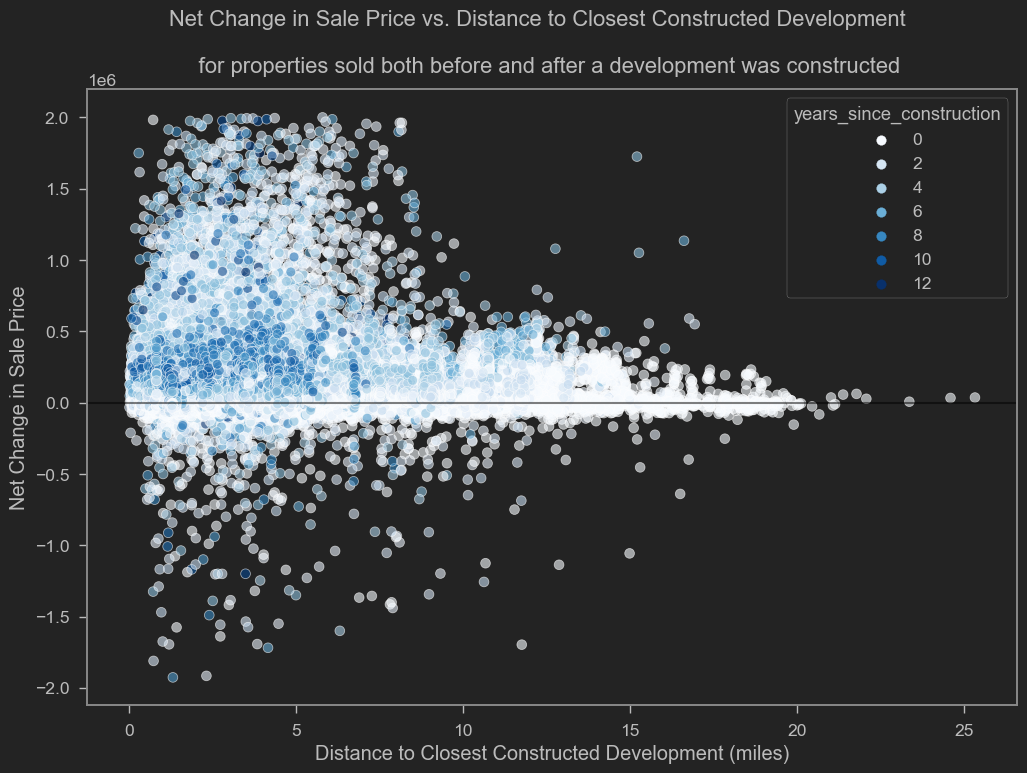

In [267]:
fig,ax = plt.subplots(figsize = (12,8))
graph = sns.scatterplot(
    data = properties.loc[(properties.net_saleamount_change <= 2_000_000) & (properties.net_saleamount_change >= -2_000_000)],
     x ='closest_dev_distance',
     y = 'net_saleamount_change',
     alpha=.6,
     hue = 'years_since_construction',
     palette = 'Blues',
)
graph.axhline(0, color='black', alpha=.5)
plt.ylabel('Net Change in Sale Price')
plt.xlabel('Distance to Closest Constructed Development (miles)')
plt.suptitle(
    """Net Change in Sale Price vs. Distance to Closest Constructed Development\n
    for properties sold both before and after a development was constructed""")


Text(0.5, 0.98, 'Percent Change in Sale Amount vs. Distance to Closest Constructed Development\n\n    for properties sold both before and after a development was constructed')

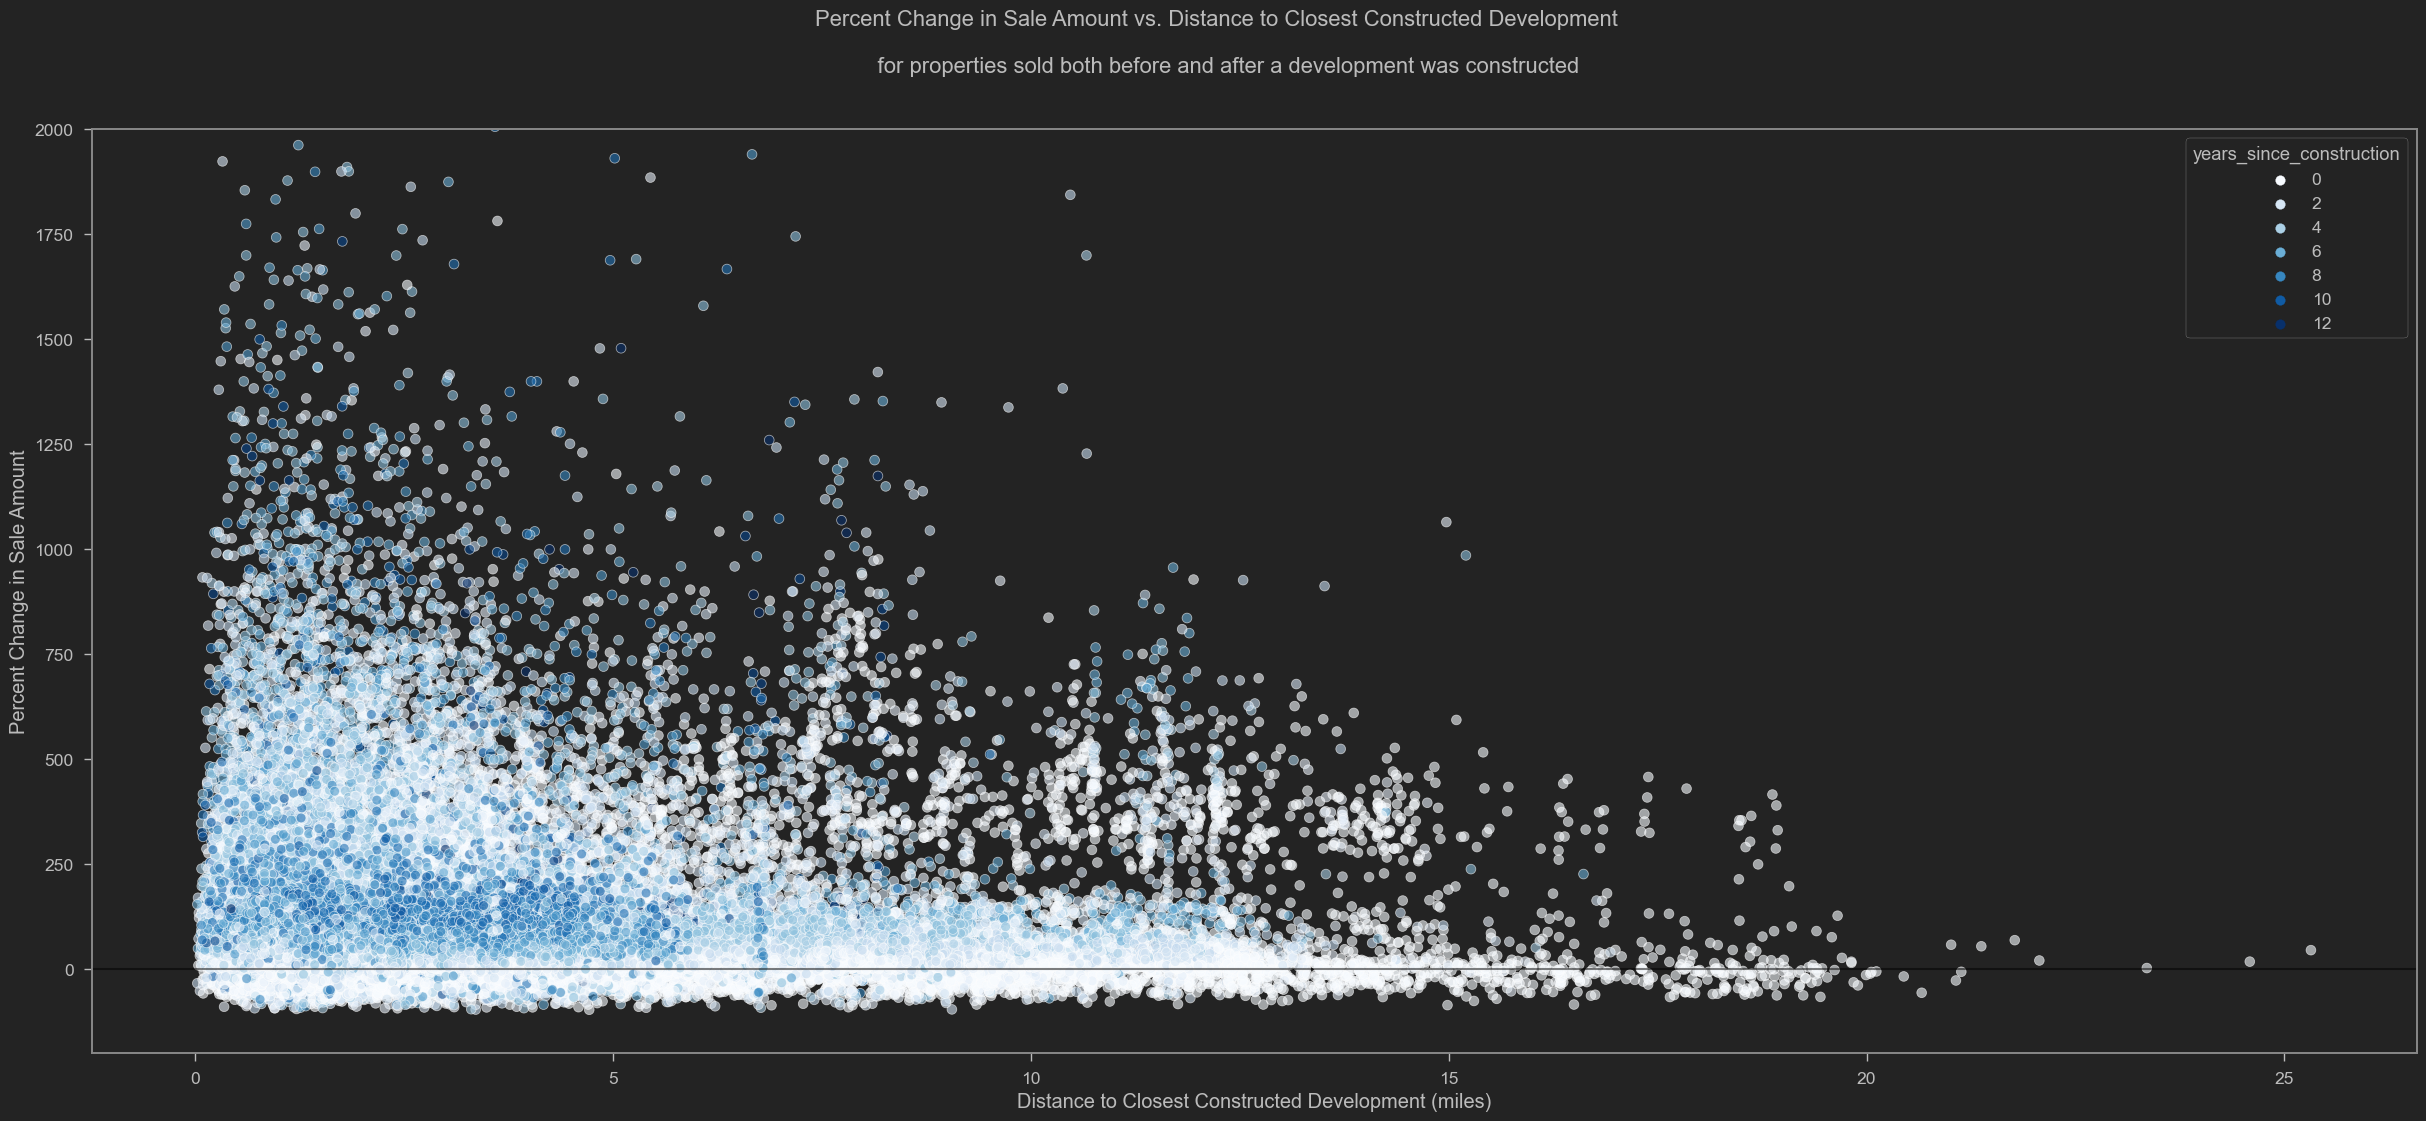

In [268]:
plt.subplots(figsize = (30,12))
graph = sns.scatterplot(
    data = properties,
     x ='closest_dev_distance',
     y = 'saleamount_increase',
     alpha=.6,
     hue = 'years_since_construction',
     palette = 'Blues',
)
plt.ylim([-200,2000])
graph.axhline(0, color='black', alpha=.5)
plt.ylabel('Percent Change in Sale Amount')
plt.xlabel('Distance to Closest Constructed Development (miles)')
plt.suptitle(
    """Percent Change in Sale Amount vs. Distance to Closest Constructed Development\n
    for properties sold both before and after a development was constructed""")

C:\Users\theoc\AppData\Local\Temp\ipykernel_19764\448497239.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(properties.corr(), dtype=np.bool))


<AxesSubplot:>

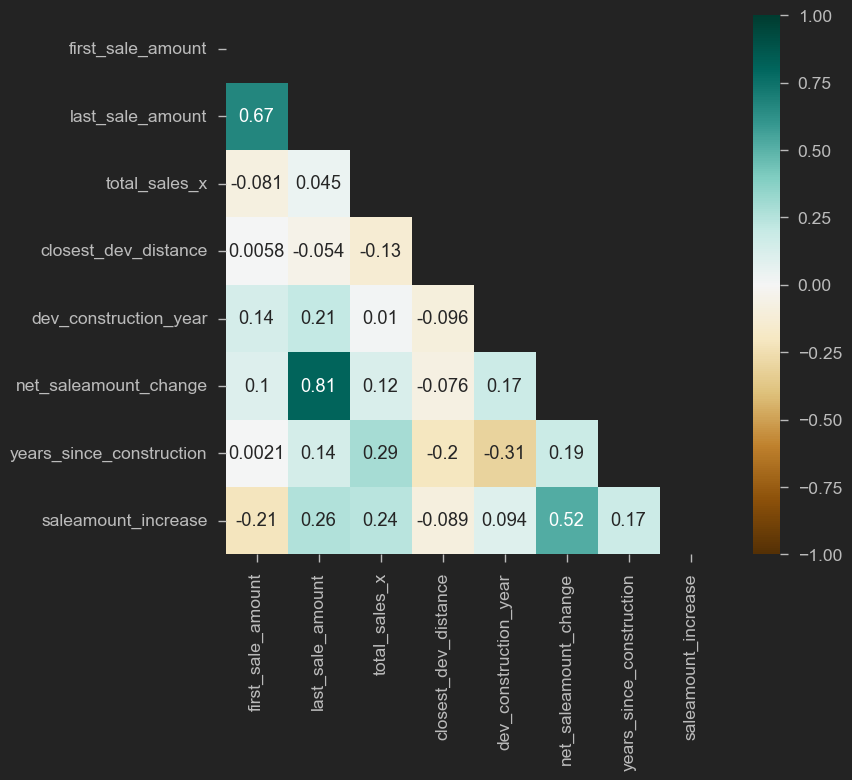

In [269]:
mask = np.triu(np.ones_like(properties.corr(), dtype=np.bool))
sns.heatmap(properties.corr(), annot=True, vmin = -1, vmax = 1, cmap='BrBG', mask=mask)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Distance'),
  Text(0, 1.5, 'Sale Amount Change'),
  Text(0, 2.5, 'Times Sold')])

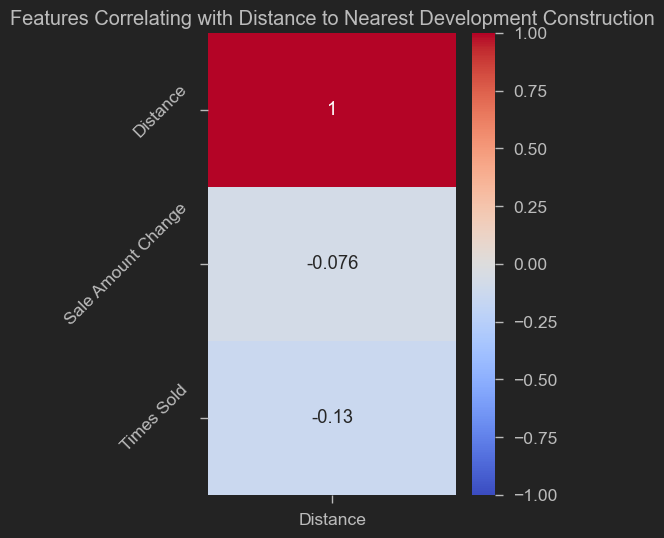

In [270]:
dummy_df = properties.copy().rename(columns = {'closest_dev_distance' : 'Distance', 'net_saleamount_change' : 'Sale Amount Change', 'total_sales_x' : 'Times Sold'})
plt.figure(figsize=(4,6))

#mask = np.triu(np.ones_like(properties.corr()[['closest_dev_distance']], dtype=np.bool))

heatmap = sns.heatmap(
    dummy_df[['Distance','Sale Amount Change', 'Times Sold']].corr()[['Distance']].sort_values(by='Distance',ascending=False),
    vmin = -1,
    vmax = 1,
    annot = True,
    cmap = 'coolwarm',
    )
heatmap.set_title('Features Correlating with Distance to Nearest Development Construction')
plt.yticks(rotation =45)

# Look at the properties that didnt have a development built now

In [276]:
reverse_properties.head(1)

apn  sale_year_x  first_sale_amount  total_sales_x  \
1  00200002700       2020.0           165000.0              4   

                              clean_center           first_sale  sale_year_y  \
1  (-86.76308736156855, 36.39356184510311)  2020-05-08 00:00:00       2022.0   

   last_sale_amount  total_sales_y            last_sale  closest_dev_distance  \
1          440000.0              4  2022-08-12 00:00:00                9999.0   

             dev_name  dev_construction_year  
1  no_dev_constructed                      0

In [277]:
# create net change for reverese properties
for index, row in reverse_properties.iterrows():
    reverse_properties.loc[index, 'net_saleamount_change'] = row.last_sale_amount - row.first_sale_amount

In [289]:
#create percentage change in saleamount column
for index, row in reverse_properties.iterrows():
    reverse_properties.loc[index, 'saleamount_increase'] = (row.net_saleamount_change / row.first_sale_amount) * 100

#### Filter out crazy values

In [298]:
old_reverse_properties = reverse_properties.copy()

In [299]:
reverse_properties = reverse_properties.loc[(reverse_properties.net_saleamount_change <= 5_000_000) & (reverse_properties.net_saleamount_change >= -5_000_000)]

(0.0, 2700.0)

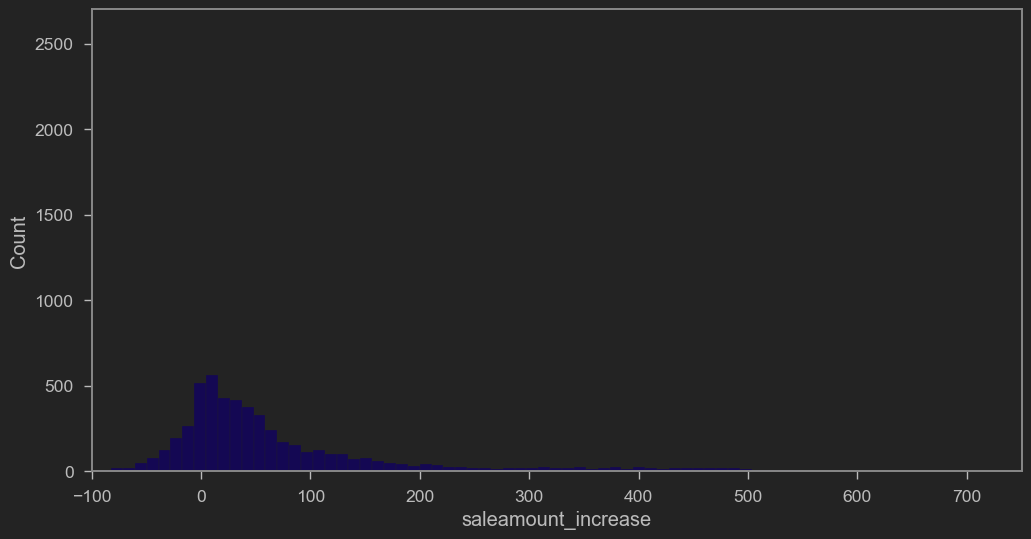

In [313]:
fig,ax = plt.subplots(figsize = (12,6))

sns.histplot(data = reverse_properties, x = 'saleamount_increase', color = '#0F0064')

plt.xlim([-100, 750])
plt.ylim([0,2700])



(0.0, 2700.0)

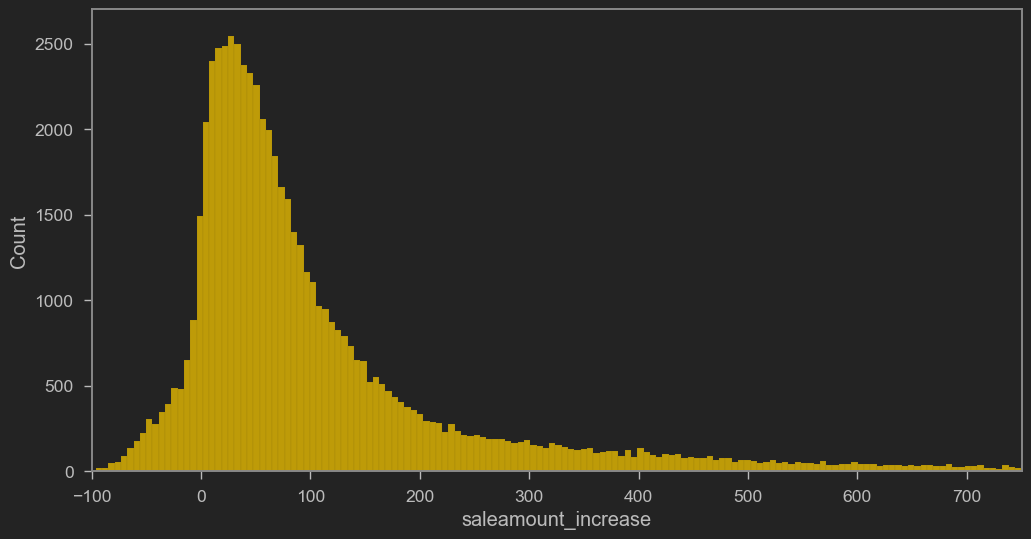

In [315]:
fig,ax = plt.subplots(figsize = (12,6))

sns.histplot(data = properties, x = 'saleamount_increase', color = '#F3C400')

plt.xlim([-100, 750])
plt.ylim([0,2700])
